In [1]:
import sys
sys.path.append('../../../patronus/')
# print(sys.path)
from global_config import * # load REPO_HOME_DIR, DATASET_DIR

import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os


from train.utils import load_patronus_unet_model
from models.diffusion import SimpleDiffusion
from train.dataloader import get_dataloader
from analysis.analysis_utils import get_samples_from_loader, vis_samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Interpolation 
Fig. 4 in the paper.
## 1 - Define the dataset and trained version that you would like to inspect on

In [2]:
ds = 'CelebA'
version_num = 4
print(f'Selecting dataset: {ds} version {version_num}')

Selecting dataset: CelebA version 4


## 2 – Load trained model, initialize diffusion schedule, load test set

In [1]:
# ---- Load the patronus model -----
print('*'*30 + 'Load model' + '*'*30)
model, patronus_config_set = load_patronus_unet_model(ds_name=ds, 
                                                    version_num=version_num,
                            )

 # ---- Load the diffusion schduler ----
sd = SimpleDiffusion(
        num_diffusion_timesteps = patronus_config_set['TrainingConfig']['TIMESTEPS'],
        img_shape               = patronus_config_set['TrainingConfig']['IMG_SHAPE'],
        device                  = patronus_config_set['BaseConfig']['DEVICE'],
)

# ---- Load the test set ----- 
# we use test set to avoid memorization from the training set
dataloader_test = get_dataloader(
        dataset_name=f'{ds}-test',
        batch_size=256,
        device='cpu',
        shuffle = True, # test set should not be shuffled
)

# # ---- Get the plausible maximum prototype similarity score ----
for i, (b_image, extra_info) in enumerate(dataloader_test):
    pact = model.proactBlock(b_image.to(device))
    b_img_id = extra_info[1]
    max_pact = torch.max(pact).detach().cpu()
    break
# print(f'Maximum prototype similarity score: {max_pact}')

## Select two samples to play with

Randomly picked sample index: tensor([40, 62])


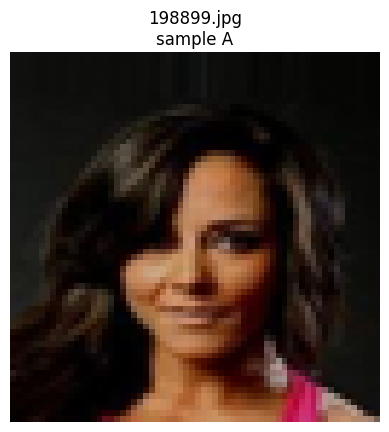

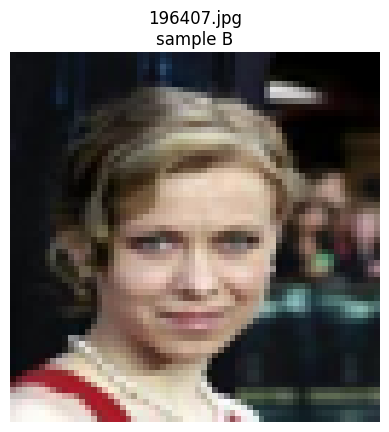

In [12]:

# selected_sample_id = ['200877.jpg'] # <-- CelebA
# selected_img = get_samples_from_loader(dataloader_test, selected_sample_id)

enforce_same_class = False

if enforce_same_class == False:
    # random select
    # torch.random.manual_seed(2025)
    random_picked_idx = torch.randint(0, len(dataloader_test), (2,))
    print(f'Randomly picked sample index: {random_picked_idx}')

else: 
    # find all samples with label 1 and randomly pick two samples
    select_label = 1 # <-- 1: blanket, 6: floor
    label_ids = []
    indexs = []

    labels = extra_info[0]
    ids = extra_info[1]

    for i in range(len(labels)):
        if labels[i].item() == select_label:
            label_ids.append(ids[i])
            indexs.append(i)
    print(f'{label_ids=},{indexs=}')
    if len(label_ids) < 2:
        raise ValueError("Not enough samples with label 1.", len(label_ids))

    import random
    indexs = random.sample(indexs, 2)
    random_picked_idx = [indexs[0], indexs[1]]
    print(f'Randomly picked sample index: {random_picked_idx}')

# get one specific image
selected_img_a = b_image[random_picked_idx[0]].unsqueeze(0)
selected_sample_id_a = [b_img_id[random_picked_idx[0]]]

selected_img_b = b_image[random_picked_idx[1]].unsqueeze(0)
selected_sample_id_b = [b_img_id[random_picked_idx[1]]]

vis_samples(selected_img_a, [selected_sample_id_a[0]+'\nsample A'])
vis_samples(selected_img_b, [selected_sample_id_b[0]+'\nsample B'])

## Get prototype activation vector and x_T

In [13]:
pact_a = model.proactBlock(selected_img_a.to(device))
xT_a = sd.reverse_sample_loop(model,selected_img_a.to(device), 
                                       model_kwargs={'given_cond_vector':pact_a})['sample']

pact_b = model.proactBlock(selected_img_b.to(device))
xT_b = sd.reverse_sample_loop(model,selected_img_b.to(device), 
                                       model_kwargs={'given_cond_vector':pact_b})['sample']

## 3 - Interpolation

In [14]:
save_dir = REPO_HOME_DIR+  f'records/evaluation/interpolation/{ds}_{version_num}/'
if os.path.exists(save_dir) == False:
    os.makedirs(save_dir)

steps=10
DEBUG:img.shape=torch.Size([10, 3, 64, 64])


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007872224..0.8458626].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007938385..0.8926101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00606817..0.88854945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0119044185..0.92352283].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016492426..0.9439712].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013835609..0.98743653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got r

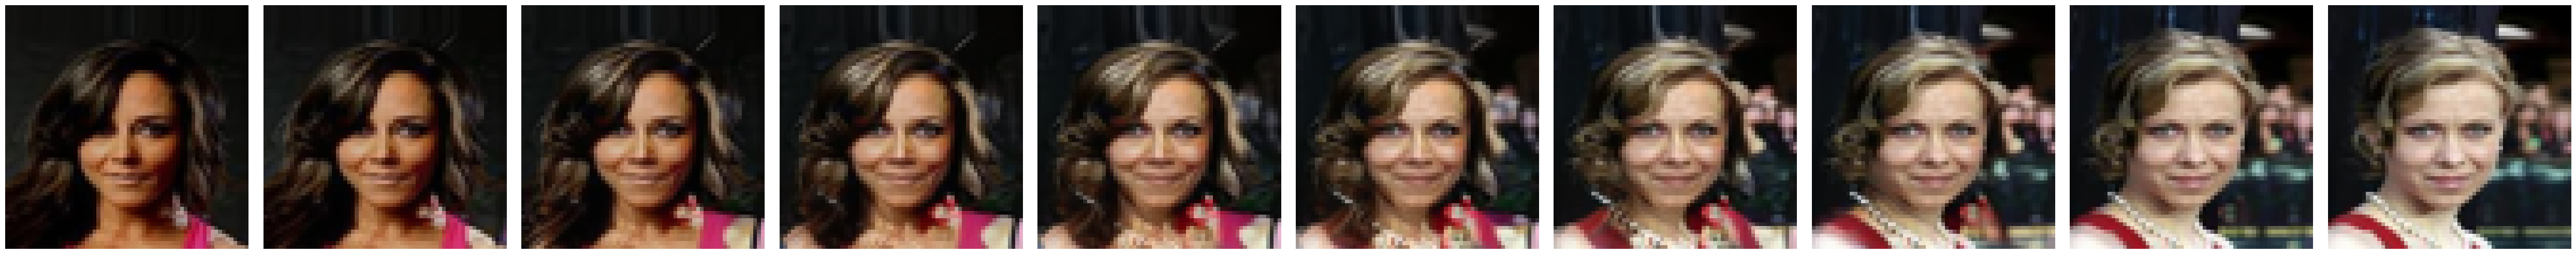

In [15]:
steps = 10 # <-- steps for interpolation

print(f'{steps=}')
alpha = torch.tensor(np.linspace(0, 1, steps, dtype=np.float32)).to(pact_a.device)
intp = pact_a[None] * (1 - alpha[:, None]) + pact_b[None] * alpha[:, None]
intp =intp[0]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT_a[0], xT_b[0]))
x_shape = xT_a[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT_a[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT_b[0].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)


pred = sd.sample(model,
                    shape=intp_x.shape,
                    noise=intp_x,
                    progress=True,
                    model_kwargs={'given_cond_vector':intp},
                    num_samples=1,
                    eta=0.0)
fig, ax = plt.subplots(1, steps, figsize=(5*steps, 5))
pred_show = (pred+1)/2
for i in range(len(alpha)):
    img_shape = pred_show[i].shape
    if img_shape[0] == 1:
        ax[i].imshow(pred_show[i].squeeze().cpu(), cmap='gray')
    else:
        ax[i].imshow(pred_show[i].permute(1, 2, 0).cpu())
    ax[i].axis('off')
plt.tight_layout()
plt.savefig(save_dir + '/{}_{}_s{}.png'.format(selected_sample_id_a[0].split('.')[0],selected_sample_id_b[0].split('.')[0],steps),bbox_inches='tight')
plt.show()